# IMPORTATION DES DONNEES

## Fonctions importantes

In [13]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from sklearn import decomposition
from scipy.cluster import hierarchy
import seaborn as sns 
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn import preprocessing
from pandas_profiling import ProfileReport
np.set_printoptions(precision=2,linewidth=500,suppress=True)

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(5,5))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(5,5))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                    #plt.annotate(X_projected.index[i],X_projected[selected, d1], X_projected[selected, d2]) # A enlever
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(18,5))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "top",
    )
    plt.show()


In [14]:
from google.colab import drive
drive.mount('/content/drive')
data=pd.read_csv('/content/drive/MyDrive/notes.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Mission 0 : Statistqiues descriptives

In [15]:
data.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


Vérification des données manquantes.

In [16]:
data.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

Nombre de billets par type

In [17]:
data.is_genuine.value_counts()

True     100
False     70
Name: is_genuine, dtype: int64

Il 100  vrais billets contre 70 faux billets dans notre jeu de données.

## Etude univariées

In [18]:
data[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']].describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


## Etude bivariées

Corrélation entre variables 

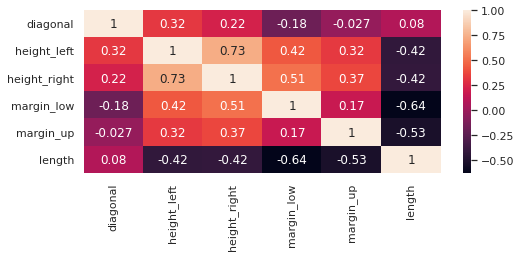

In [19]:
plt.figsize=(7,2)
corr=data[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']].corr()
sns.heatmap(corr,xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.show()

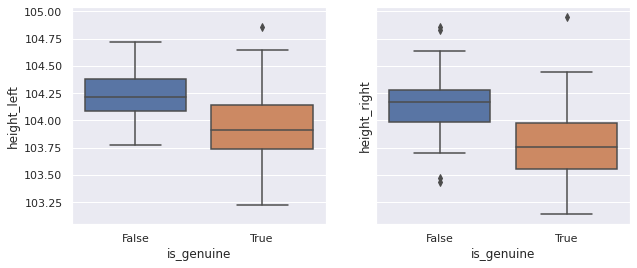

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
sns.set(rc={'figure.figsize':(6,5)})
#plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.2)
sns.boxplot(ax=axes[0],data=data, x='is_genuine', y='height_left')
sns.boxplot(ax=axes[1],data=data, x='is_genuine', y='height_right')

On voit d'après le graphique ci-dessus que les feux billets la hauteur des faux billets est généralement plus grande que celle des vrais billets.

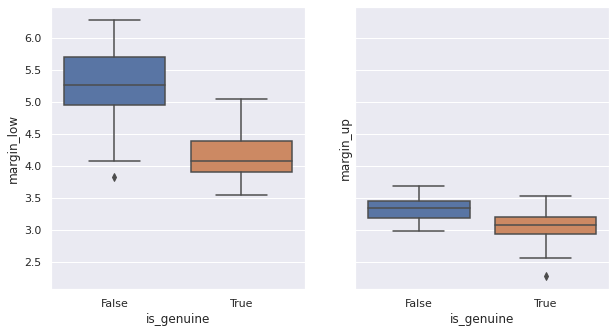

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
sns.set(rc={'figure.figsize':(6,5)})
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.2)
sns.boxplot(ax=axes[0],data=data, x='is_genuine', y='margin_low')
sns.boxplot(ax=axes[1],data=data, x='is_genuine', y='margin_up')

La marge des faux billets a tendance à tendance à être plus grande que celle des vrais billets.

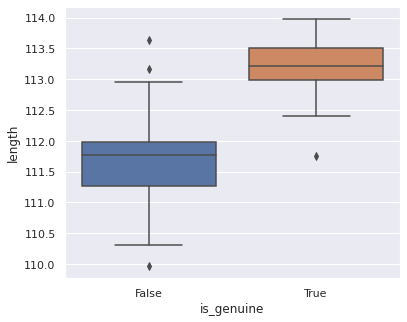

In [22]:
sns.set(rc={'figure.figsize':(6,5)})
sns.boxplot(data=data, x='is_genuine', y='length')

La longueur des faux billets a tendance à être plus grande que celle des vrais billets.

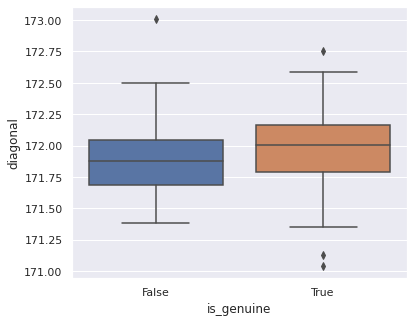

In [23]:
sns.set(rc={'figure.figsize':(6,5)})
sns.boxplot(data=data, x='is_genuine', y='diagonal')

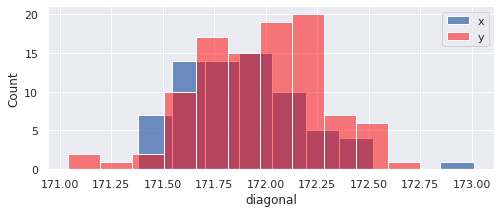

In [24]:
sns.set(rc={'figure.figsize':(8,3)})
sns.histplot(data[data.is_genuine==False].diagonal, alpha=0.8, label='x')
sns.histplot(data[data.is_genuine==True].diagonal, alpha=0.5, color='red',label='y')
plt.legend(loc='upper right')
plt.show()

Les vrais billets ont tendance à avoir une diagonale plus grande que les faux billets.

# Mission 1 : ACP

In [25]:
# choix du nombre de composantes à calculer
n_comp =6

# Variable illustratiive
var_illust=list(data['is_genuine'])

# préparation des données pour l'ACP
X=data[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']].values
variables = data[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']].columns
#X=data.values
#variables = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)
print(X_scaled)


[[-0.43  2.67  3.1  -0.13 -1.19  0.28]
 [-0.89 -1.1  -0.69 -0.86 -1.27  0.78]
 [-0.36 -1.03 -0.51 -0.3  -1.23  1.38]
 ...
 [ 1.74  0.68  0.52  0.38  0.68 -2.05]
 [-0.4  -0.32 -0.15  0.17  1.61 -0.76]
 [ 0.06 -0.22  0.07  1.45  0.38 -1.75]]


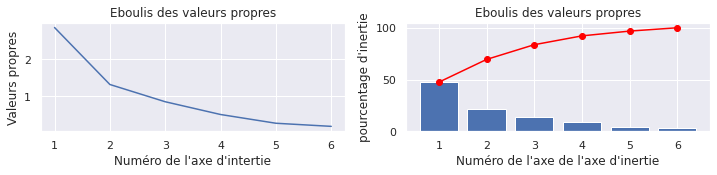

In [26]:
# Calcul des valeurs propres  (valeur propre = variance)
n= X.shape[0]  # nombres d'individus
p= X.shape[1]  # Nombre de varaiables
valeurs_propres=(n-1)/n*pca.explained_variance_ #valeur corrigée  (n-1)/n ,  on peut aussi faire :  acp.singular_values_**2/n

# Grpahique 
fig, axes =plt.subplots(1,2, figsize=(12,2))
p=X.shape[1]  # Nombre de variables
axes[0].plot(np.arange(1,p+1),valeurs_propres )
axes[0].set_title("Eboulis des valeurs propres")
axes[0].set_ylabel("Valeurs propres")
axes[0].set_xlabel("Numéro de l'axe d'intertie")


eboulis = pca.explained_variance_ratio_*100    #  Pourcentage de la variance ( pourcentage valeur propre)
axes[1].bar(np.arange(len(eboulis))+1, eboulis)
axes[1].plot(np.arange(len(eboulis))+1, eboulis.cumsum(),c="red",marker='o')
axes[1].set_xlabel("Numéro de l'axe de l'axe d'inertie")
axes[1].set_ylabel("pourcentage d'inertie")
axes[1].set_title("Eboulis des valeurs propres")
plt.show(block=False)

Nous disposons des éléments permettant de construire le graphique éboulis des  valeurs propres. En utilisant la règle règle du coude pour identifier le nombre de facteurs K à retenir, nous conclons que la solution (K= 2) semble s’imposer ici. Les deux premières composantes accaprent 69% de l'information. Nous 
obtenons de 84% avec les 3 premiers facteurs

On peut alternativement utiliser la règle des bâtons brisés pour detrminer le nombre de facteurs à retenir. Le facteur n°k est validé si ($\lambda_k$ >  $b_k = \sum_{i=k}^{p} \frac{1}{i}$), où λk est la valeur propre associée à l’axe n°k.

In [27]:
#seuils pour test des bâtons brisés
bs = 1/np.arange(p,0,-1)
bs = np.cumsum(bs)
bs = bs[::-1]

#Puis affichons conjointement les valeurs propres et les seuils :
#test des bâtons brisés
print(pd.DataFrame({'Val.Propre':valeurs_propres,'Seuils':bs}))

   Val.Propre    Seuils
0    2.846875  2.450000
1    1.317426  1.450000
2    0.854071  0.950000
3    0.511578  0.616667
4    0.276769  0.366667
5    0.193280  0.166667


- Cercle des corrélations

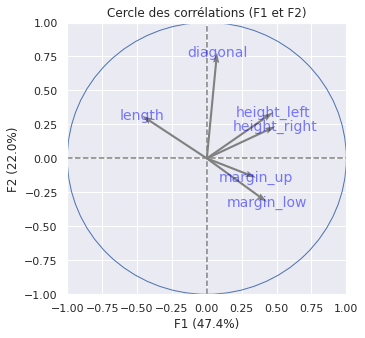

In [28]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)],  labels = np.array(variables))

- Représentation des individus

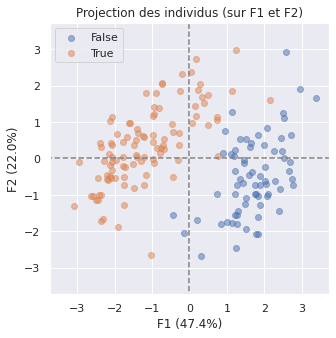

In [29]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)],illustrative_var = var_illust, alpha = 0.5)

# Contribution des individus : $CTR_k(i) =
\frac{{F^2_{𝑖𝑘}}} {n λ_{k}}$, avec $ F^2_{𝑖𝑘} $ = coordonnées de l'individu $i$ sur l'axe $k$


In [30]:
comp_princ=pd.DataFrame(X_projected, index=data.index, columns=["F"+str(i+1) for i in range(6)]).copy()
comp_princ

,F1,F2,F3,F4,F5,F6
0,2.153639,1.599709,1.787451,2.433465,0.699690,-1.267702
1,-2.110416,-0.526039,0.542563,0.344550,0.067440,-0.544601
2,-1.973152,-0.048102,0.858716,0.374812,-0.424886,0.080487
3,-2.059795,-0.089105,-0.531529,0.519548,-0.033267,-0.038261
4,-2.403180,0.412170,3.319507,-0.837043,-0.420151,-0.445099
...,...,...,...,...,...,...
165,2.478626,0.189974,-0.814598,0.107861,-0.899828,0.093078
166,2.585331,2.914472,0.586789,-2.183704,0.274577,-0.509206
167,2.067245,0.845602,-0.610282,-1.714172,0.116958,-0.504338
168,0.739257,-0.972965,-1.359772,-0.191736,-0.243557,0.211429


In [31]:
#contributions aux axes
"""ctr = X_projected**2
for j in range(p):
 ctr[:,j] = ctr[:,j]/(n*valeurs_propres[j])
print(pd.DataFrame({'id':data.index,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1]}))"""

comp_princ["F1"] =(comp_princ["F1"]**2)/(n*valeurs_propres[0]).copy()
comp_princ["F2"] =(comp_princ["F2"]**2)/(n*valeurs_propres[1]).copy()
comp_princ["F3"] =(comp_princ["F3"]**2)/(n*valeurs_propres[2]).copy()
comp_princ["F4"] =(comp_princ["F4"]**2)/(n*valeurs_propres[3]).copy()
comp_princ["F5"] =(comp_princ["F5"]**2)/(n*valeurs_propres[4]).copy()
comp_princ["F6"] =(comp_princ["F6"]**2)/(n*valeurs_propres[5]).copy()
comp_princ

,F1,F2,F3,F4,F5,F6
0,0.009584,0.011426,0.022005,0.068091,0.010405,0.048910
1,0.009203,0.001236,0.002027,0.001365,0.000097,0.009027
2,0.008045,0.000010,0.005079,0.001615,0.003837,0.000197
3,0.008767,0.000035,0.001946,0.003104,0.000024,0.000045
4,0.011933,0.000759,0.075893,0.008056,0.003752,0.006029
...,...,...,...,...,...,...
165,0.012694,0.000161,0.004570,0.000134,0.017209,0.000264
166,0.013811,0.037927,0.002371,0.054831,0.001602,0.007891
167,0.008830,0.003193,0.002565,0.033787,0.000291,0.007741
168,0.001129,0.004227,0.012735,0.000423,0.001261,0.001360


In [32]:
comp_princ_perc = comp_princ*100
comp_princ_perc[comp_princ_perc['F3']>2] # Contribution supérieures à 2%

,F1,F2,F3,F4,F5,F6
0,0.958359,1.142633,2.200519,6.809100,1.040504,4.891014
4,1.193315,0.075854,7.589341,0.805628,0.375184,0.602944
15,0.635202,0.112823,3.293000,0.286926,0.017095,2.147459
18,0.454652,0.059042,3.200310,0.052248,1.249142,0.166575
106,0.380699,0.123917,2.335401,0.035680,0.365380,0.524179
149,0.310873,0.428512,2.083617,0.309823,0.714141,0.000885
158,1.583607,0.242331,2.777754,0.149426,0.252784,0.717561
159,1.203893,0.306441,2.284400,0.000281,3.422298,3.037839
160,0.182252,0.245784,5.009638,4.354477,0.335951,0.547772


In [33]:
comp_princ[comp_princ["F1"]>=2*comp_princ["F1"].mean()].count() # Contributions supérieures à 2 fois la moyenne des contributions sur l'axe 1

F1    23
F2    23
F3    23
F4    23
F5    23
F6    23
dtype: int64

Critère :
Il faut se méfier si un individu a une
contribution excessive, car cela est un facteur d’instabilité : retirer cet individu modifie profondément
le résultat de l’analyse. On peut réaliser une ACP en le retirant et considérer alors sa projection dans
les sous-espaces principaux.
Il faut isoler les individus qui ont un comportement exceptionnel (ou aberrant).
Ceux qui concentrent la moitié ou presque des contributions.
Si la contribution d’un individu à un ou plusieurs axes est beaucoup plus importante que celle
des autres il faut vérifier si cet individu n’est pas abberrant.


- Contributions des deux groupes aux différents axes.

In [34]:
axes= ["F"+str(i+1) for i in range(6)]
for ax in axes :
  print(pd.merge(comp_princ.nlargest(50,ax), data['is_genuine'],  left_index=True, right_index=True)['is_genuine'].value_counts(normalize=True))

True     0.58
False    0.42
Name: is_genuine, dtype: float64
True     0.52
False    0.48
Name: is_genuine, dtype: float64
True     0.5
False    0.5
Name: is_genuine, dtype: float64
True     0.56
False    0.44
Name: is_genuine, dtype: float64
True     0.54
False    0.46
Name: is_genuine, dtype: float64
False    0.52
True     0.48
Name: is_genuine, dtype: float64


## Qualités de la représentation des individus :$𝐶𝑂𝑆^2_{𝑖𝑘} =\frac{{F^2_{𝑖𝑘}}}{𝑑𝑖^2}$ ,  avec    $ F^2_{𝑖𝑘} $ = coordonnées de l'individu $i$ sur l'axe $k$


In [35]:
#contribution des individus dans l'inertie totale
di = np.sum(X_projected**2,axis=1)
print(pd.DataFrame({'ID':data.index,'d_i':di, 'type': data.is_genuine}).nlargest(12,'d_i'))

      ID        d_i   type
166  166  20.625650  False
0      0  18.410598   True
4      4  18.039567   True
122  122  16.790944  False
39    39  15.052608   True
112  112  14.422407  False
151  151  13.637281  False
49    49  12.917538   True
160  160  12.831169  False
158  158  12.724639  False
159  159  12.438171  False
5      5  11.527985   True


In [36]:
#qualité de représentation des individus - COS2
cos2 = X_projected**2
for j in range(p):
 cos2[:,j] = cos2[:,j]/di
print(pd.DataFrame({'id':data.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1],'COS2_3':cos2[:,2],'COS2_4':cos2[:,3]}))

      id    COS2_1    COS2_2    COS2_3    COS2_4
0      0  0.251929  0.139000  0.173540  0.321649
1      1  0.818002  0.050822  0.054065  0.021803
2      2  0.784862  0.000466  0.148652  0.028320
3      3  0.882856  0.001652  0.058789  0.056169
4      4  0.320145  0.009417  0.610831  0.038839
..   ...       ...       ...       ...       ...
165  165  0.800651  0.004703  0.086479  0.001516
166  166  0.324059  0.411824  0.016694  0.231196
167  167  0.498809  0.083461  0.043472  0.342972
168  168  0.156908  0.271800  0.530870  0.010555
169  169  0.421817  0.217111  0.006645  0.338179

[170 rows x 5 columns]


- Qualité de représentation des individus sur le premier plan factoriel.

In [37]:
ct=pd.DataFrame({'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]})
ct["ctr_F1_F2"] = ct["COS2_1"]+ct["COS2_2"]

In [41]:
ct["ctr_F1_F2"].quantile(0.22)

0.5083348640336426

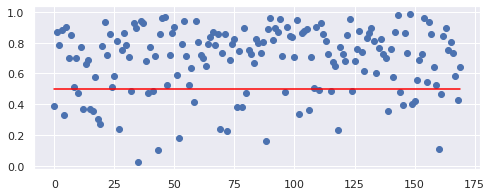

In [39]:
plt.scatter(x=ct.index,y=ct["ctr_F1_F2"])
plt.plot(ct.index,np.repeat(0.5,len(ct)), color='red')

On voit que pour plus 80 % des individus la qualité de représentation sur le premier plan factoriel est supérieure à 50%. 

Critères : Un $cos^2$ égal à 0.9 correspond à un angle de 18
degrés. Par contre, une valeur de 0.5 correspond à un angle
de 45 degrés !
On peut considérer les valeurs supérieures à 0.80 comme
bonnes et des valeurs inf´erieures à 0.5 comme mauvaises.
Attention ! Une mauvaise qualité n’est significative que
quand le point projeté n’est pas trop près de 0. Sinon on ne
peut pas conclure à partir de ce simple nombre. Grâce à la qualité, on sélectionne les individus intéressants.



# Mission 2: Algorithme de classification

- Méthode K-means clustering

In [42]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2).fit(data[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']])
centroids = kmeans.cluster_centers_
print(centroids)

[[171.97 103.96 103.78   4.16   3.06 113.22]
 [171.89 104.23 104.15   5.28   3.33 111.63]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


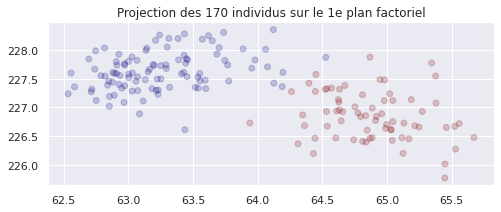

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import decomposition

# Nombre de clusters souhaités
n_clust = 2

# préparation des données pour le clustering
X1 = data[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']].values

# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
#X1_scaled = preprocessing.StandardScaler().fit_transform(X1)

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X1)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca1 = decomposition.PCA(n_components=3).fit(X1)
X1_projected = pca.transform(X1)
plt.scatter(X1_projected[:, 0], X1_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X1_projected.shape[0]))
plt.show(block=False)

- Classification hiéarachique ascendante

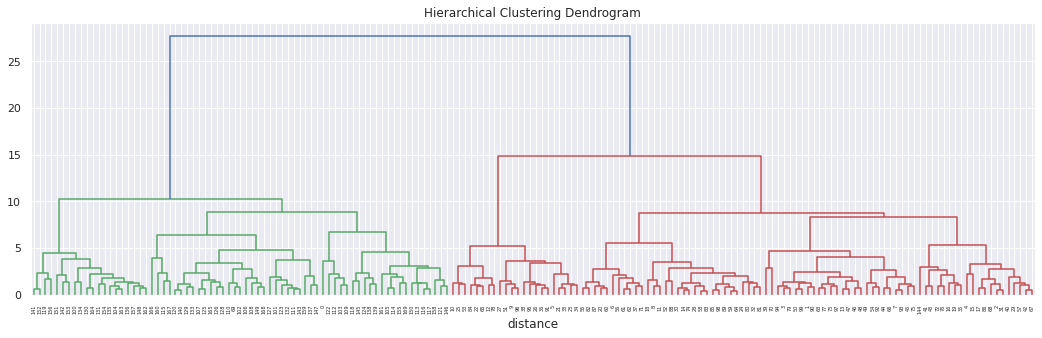

In [45]:
import pandas as pd
#from functions import plot_dendrogram
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn import preprocessing

# Theme du ou des parcours auxquels appartient le cours (data, developpement, marketing, etc.)
theme = data[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']].index

# préparation des données pour le clustering
X2 = data[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']].values
names = data[['diagonal',	'height_left',	'height_right',	'margin_low',	'margin_up',	'length']].index

# Centrage et Réduction
std_scale1 = preprocessing.StandardScaler().fit(X2)
X2_scaled = std_scale1.transform(X2)

# Clustering hiérarchique
Z = linkage(X2_scaled, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, names)

# Régression logistique 

In [46]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

- Préparation des données

In [54]:
#y (is_genuine) est la première colonne
Y = data.iloc[:,0]
#X (les autres) sont les variables qui qui viennent après la première colonne
X = data.iloc[:,1:]
# On partage les données en deux groupes : les données d'entraienement et les données test
XTrain,XTest,yTrain,yTest = train_test_split(X,Y,test_size=0.25)

- Création du modèle

In [55]:
model=LogisticRegression(penalty='none')
model.fit(XTrain,yTrain)

LogisticRegression(penalty='none')

In [56]:
#affichage des coefficients
print(pd.DataFrame({"var":XTrain.columns,"coef":model.coef_[0]}))
#Affichage de la constante
print(model.intercept_)

            var        coef
0      diagonal    0.849694
1   height_left  -52.164396
2  height_right  -42.910073
3    margin_low -221.072182
4     margin_up -236.713315
5        length  102.569547
[-0.47]


In [57]:
#probabilités d'affectation
proba01 = model.predict_proba(XTrain)
#affichage des 5 premières valeurs
print(proba01[:5,:])

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


Les probabilités sont sur deux colonnes. La première, n°0, pour l’appartenance à (Y = 0), la 
seconde pour (Y = 1).

- Test du model

In [58]:
#appliquer la prédiction
prediction = model.predict(XTest)
print(np.unique(prediction,return_counts=True))
print(prediction)
print(yTest)

(array([False,  True]), array([17, 26]))
[False  True  True False False  True  True False  True False  True  True False  True  True  True  True  True False  True False False False  True  True False False  True  True False False False  True  True  True  True False  True  True  True  True False  True]
127    False
36      True
5       True
147    False
112    False
39      True
19      True
154    False
15      True
100    False
85      True
98      True
138    False
93      True
16      True
71      True
0       True
83      True
134    False
58      True
162    False
107    False
159    False
78      True
87      True
108    False
122    False
1       True
6       True
120    False
137    False
128    False
88      True
21      True
31      True
52      True
153    False
54      True
4       True
55      True
74      True
116    False
12      True
Name: is_genuine, dtype: bool


- Matrice de confusion

In [52]:
#matrice de confusion
print(metrics.confusion_matrix(yTest,prediction))

[[16  0]
 [ 0 27]]


- Rapport sur la qualité de prédiction 

In [53]:
#rapport sur la qualité de prédiction
print(metrics.classification_report(yTest,prediction))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        16
        True       1.00      1.00      1.00        27

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43

